TODO:

- take potentials of all nodes and average
- log every NetCon effectively
- Do only KII set and give input

### Install Neuron

In [1]:
!pip3.8 install neuron requests seaborn matplotlib

You should consider upgrading via the '/home/tlh/myownstuff/olfactory/python_notebooks/.venv/bin/python3.8 -m pip install --upgrade pip' command.


In [2]:
import time
totalstart = time.time()
import os
if os.getcwd() != "/content":
    # we are not in google colab, assume hebbian library is in current dir
    from hebb_test import ORN, MCELL, GCELL
else:
    # download from git
    import shutil, requests
    url = 'https://cloud.operationtulip.com/s/MdM955dETWo9Cke/download/git.zip'
    response = requests.get(url, stream=True)
    with open('git.zip', 'wb') as out_file:
        shutil.copyfileobj(response.raw, out_file)
    del response
    import zipfile
    with zipfile.ZipFile('git.zip', 'r') as zip_ref:
        zip_ref.extractall('')


In [3]:
!nrnivmodl

/home/tlh/myownstuff/olfactory/python_notebooks/test
Mod files: "./blr3000.mod" "./blr3001.mod" "./blr3002.mod" "./blr3003.mod" "./ciliaProp.mod" "./dendProp.mod" "./hh1.mod"

COBJS=''
 -> Compiling mod_func.c
gcc -O2   -I.   -I/home/tlh/myownstuff/olfactory/python_notebooks/.venv/lib/python3.8/site-packages/neuron/.data/include  -I/nrnwheel/openmpi/include -fPIC -c mod_func.c -o mod_func.o
 => LINKING shared library ./libnrnmech.so
g++ -O2 -DVERSION_INFO='8.0.0' -std=c++11 -shared -fPIC  -I /home/tlh/myownstuff/olfactory/python_notebooks/.venv/lib/python3.8/site-packages/neuron/.data/include -o ./libnrnmech.so -Wl,-soname,libnrnmech.so \
  ./mod_func.o ./blr3000.o ./blr3001.o ./blr3002.o ./blr3003.o ./ciliaProp.o ./dendProp.o ./hh1.o  -L/home/tlh/myownstuff/olfactory/python_notebooks/.venv/lib/python3.8/site-packages/neuron/.data/lib -lnrniv -Wl,-rpath,/home/tlh/myownstuff/olfactory/python_notebooks/.venv/lib/python3.8/site-packages/neuron/.data/lib   
rm -f ./.libs/libnrnmech.so ; mk

In [4]:
from neuron import h #.h is a HOC object instance & gui from neuron can also be imported 
from math import pi                  
from neuron.units import ms,mV
from hebb_test import ORN, MCELL, GCELL
h.load_file('stdrun.hoc')                #Allows us to do a high level simulation
pc = h.ParallelContext()
import random  
import matplotlib.pyplot as plt1

from bokeh.io import output_notebook
import bokeh.plotting as plt2
output_notebook()

import seaborn as sns

Loading BokehJS ...

## Helper Functions

In [5]:
def stairstep(lo: float, hi: float, duration: int, max_duration: int = 200, noise: list = []) -> list:
    # duration and max_duration are in ms
    ans = [lo if i < duration else hi for i in range(0,max_duration)]
    # assert len(ans) == len(noise)
    if len(noise) == 0:
        return ans
    else:
        return [ans[i]+noise[i] for i in range(len(ans))]
    # return [0+0.8*(i/duration) if i < duration else 0 for i in range(0,max_duration)]
    # visualize input 

In [6]:
def netConMaker(source, dest, weights, delay, threshold, place='axon', type='exc'):
    # print(source, dest)
    if place == 'axon':
        if type == 'exc':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendexcisyn, sec=source.axon)
        elif type == 'inh':
            netcon = h.NetCon(source.axon(0.5)._ref_v, dest.dendinhisyn, sec=source.axon)
    elif place == 'soma':
        if type == 'exc':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendexcisyn, sec=source.soma)
        elif type == 'inh':
            netcon = h.NetCon(source.soma(0.5)._ref_v, dest.dendinhisyn, sec=source.soma)
    netcon.weight[0] = weights
    netcon.delay = delay
    netcon.threshold = threshold
    return netcon

In [7]:
def plotCell(source, name, addendum=''):
    recording_cell = source
    cell_axon = h.Vector().record(recording_cell.axon(0.5)._ref_v)
    cell_dend = h.Vector().record(recording_cell.dend(0.5)._ref_v)
    t = h.Vector().record(h._ref_t)

    h.finitialize(-70 * mV)
    h.continuerun(200 * ms)

    f = plt2.figure(x_axis_label='t (ms)', y_axis_label='v (mV)')
    f.line(t, list(cell_axon), line_width=1,legend_label=name+' axon '+addendum,line_color='black')
    f.line(t, list(cell_dend), line_width=2,legend_label=name+' dendrite '+addendum,line_color='red', line_dash='dashed')
    plt2.show(f)

In [8]:
import math
def generate_L_weight_delta(first, second):
    A_plus = 0.01
    A_minus = -0.011
    tau_pre =20*ms
    tau_post =20*ms
    delta_t = [(second[iter] - first[iter]) for iter in range(min(len(first),len(second)))]
    delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(first),len(second)))]  
    delta_w = sum(delta_w_list)
    return delta_w

In [9]:
from IPython.display import HTML, display
import time

def progress(value, max=100):
    return HTML("""
        <progress
            value='{value}'
            max='{max}',
            style='width: 100%'
        >
            {value}
        </progress>
    """.format(value=value, max=max))

## Network Definitions

In [10]:
class AON:
    def __init__(self,M,weights,delay1=1,delay2=1,delay3=1,delay4=1):
        wMM=weights[0]
        wMG=weights[1]
        wGM=weights[2]
        wGG=weights[3]
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 0
        self.M1=MCELL(1,self.M)
        self.M2=MCELL(2,self.M)
        self.G1=MCELL(3,self.M)
        self.G2=MCELL(4,self.M)
        self.cells = [self.M1, self.M2, self.G1, self.G2]
        
        self.nc0 = netConMaker(self.M1, self.M2, wMM, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to E2
        self.nc1 = netConMaker(self.M2, self.M1, wMM, delay2+self.maindelay, self.th, 'soma') #Connecting E2 to E1
        self.nc2 = netConMaker(self.M2, self.G1, wMG, delay2+self.maindelay, self.th, 'soma') #Connecting E2 to I1
        self.nc3 = netConMaker(self.G1, self.M2, wGM, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to E2
        self.nc4 = netConMaker(self.G1, self.G2, wGG, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to I2
        self.nc5 = netConMaker(self.G2, self.G1, wGG, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting I2 to I1
        self.nc6 = netConMaker(self.G2, self.M1, wGM, delay4+self.maindelay, self.th, 'soma', type='inh') #Connecting I2 to E1
        self.nc7 = netConMaker(self.M1, self.G2, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to I2
        self.nc8 = netConMaker(self.M1, self.G1, wMG, delay1+self.maindelay, self.th, 'soma') #Connecting E1 to I1
        self.nc9 = netConMaker(self.G1, self.M1, wGM, delay3+self.maindelay, self.th, 'soma', type='inh') #Connecting I1 to E1

In [11]:
#Gives one 2 coupled neuron using freeman's topology in olfactory bulb
class CONNECTING:

    def __init__(self,M,weights,delay1=1,delay2=2,delay3=3,delay4=4):
        wMM=0.3
        wMG=5
        wGM=0.2
        wGG=0.25
        
        self.M = M #Set no.
        self.th = -70
        self.maindelay = 0
        
        
        #Giving current pulse
        # self.stim = h.IClamp(self.orn.ciliumArr[0](0.5))  #P1.soma to P1.dend

        # print(dir(self.stim))
        # self.input.play(self.stim,h._ref_t,True)
    
        # self.stim.amp = 0.1 #in nA      # from 0.2 to 1.8 
    
        # 4-coupled
        self.cells = []
        self.M1=MCELL(1,self.M)
        self.M1.nseg = 20
        self.M2=MCELL(2,self.M)
        self.M2.nseg = 20
        self.G1=GCELL(3,self.M)
        self.G1.nseg = 20
        self.G2=GCELL(4,self.M)
        self.G2.nseg = 20
        # self.orn=ORN(0,self.M)
        self.cells.extend([self.M1, self.M2, self.G1, self.G2])
        
#         self.stim = h.IClamp(0.9, sec=self.M1.dend)
#         self.stim.delay = self.maindelay   #in ms
#         self.stim.dur = 100     #in ms
#         self.stim.amp = 0.8  #in nA
#         print(rand_num)
        # self.nc0 = netConMaker(self.orn, self.M1, weights[M], self.maindelay, self.th) #Connecting ORN to P1
        self.nc4 = netConMaker(self.M1, self.M2, wMM, delay2+self.maindelay, self.th) #Connecting M1 to M2
        self.nc5 = netConMaker(self.M2, self.M1, wMM, delay2+self.maindelay, self.th) #Connecting M2 to M1
        self.nc6 = netConMaker(self.M2, self.G1, wMG, delay2+self.maindelay, self.th) #Connecting M2 to G1
        self.nc7 = netConMaker(self.G1, self.M2, wGM, delay3+self.maindelay, self.th, type='inh') #Connecting G1 to M2
        self.nc8 = netConMaker(self.G1, self.G2, wGG, delay3+self.maindelay, self.th, type='inh') #Connecting G1 to G2
        self.nc9 = netConMaker(self.G2, self.G1, wGG, delay4+self.maindelay, self.th, type='inh') #Connecting G2 to G1
        self.nc10 = netConMaker(self.G2, self.M1, wGM, delay4+self.maindelay, self.th, type='inh') #Connecting G2 to M1
        self.nc11 = netConMaker(self.M1, self.G2, wMG, delay1+self.maindelay, self.th) #Connecting M1 to G2
        self.nc12 = netConMaker(self.M1, self.G1, wMG, delay1+self.maindelay, self.th) #Connecting M1 to G1
        self.nc13 = netConMaker(self.G1, self.M1, wGM, delay3+self.maindelay, self.th, type='inh') #Connecting G1 to M1
                
        # give input
        
        # self.stimArr = [h.IClamp(self.orn.ciliumArr[i](0.5)) for i in range(len(self.orn.ciliumArr))]
        # self.noise = np.random.normal(0, 0.01, 200)
#         self.input = h.Vector([0.1 if i==100 else 0 for i in range(200)])
        self.input = h.Vector([0,2,0])
        self.stim = h.IClamp(0.5, sec=self.M1.dend)
        self.stim.delay = 0   #in ms
        self.stim.dur = 1e9    #in ms
        self.stim.amp = 0
#         self.tv = h.Vector([i for i in range(200)])
        self.tv = h.Vector([100,100,100])
        self.input.play(self.stim._ref_amp, self.tv, 1)
        h.nrncontrolmenu()
        g = h.Graph()
        g.size(0,200,-1,1)
        self.input.plot(g)
        h.continuerun(300)

In [12]:
class LATERAL:
    """Laterally coupling N-2 coupled neurons
    """
    def __init__(self,N,weights):
        wMML=0.3
        wGGL=0.25
        
        self.N = N
        self.th = -70
        self.maindelay = 0
        self.sets = [CONNECTING(i, weights) for i in range(N)]

        # self.fourCupArr = []
        # for r in range(1,N-1):
        #     for j in range(N-r):
        #         netConList = []
                
        #         netConList.append(netConMaker(self.sets[j].M1, self.sets[j+r].M1, wMML, self.maindelay, self.th, 'soma')) #Connect M1[0] to M1[1]
        #         netConList.append(netConMaker(self.sets[j+r].M1, self.sets[j].M1, wMML, self.maindelay, self.th, 'soma')) #Connect M1[1] to M1[0]
        #         netConList.append(netConMaker(self.sets[j].G1, self.sets[j+r].G1, wGGL, self.maindelay, self.th, 'soma', 'inh')) #Connecting G1[0] to G1[1]
        #         netConList.append(netConMaker(self.sets[j+r].G1, self.sets[j].G1, wGGL, self.maindelay, self.th, 'soma', 'inh')) #Connecting G1[1] to G1[0]
        #         self.fourCupArr.append(netConList)


        # add AON and PC
        # self.AON = AON(5,weights)
        # self.PC = AON(6,weights)
        # self.DPC = MCELL(7,self.N)
        # add noise to AON's M1
        # self.stim = h.IClamp(self.AON.M1.dend(0.5))  #P1.soma to P1.dend
        # self.noise = np.random.normal(0, 2, 300)
        # self.input = h.Vector(self.noise)
        # self.input.play(self.stim, self.stim._ref_amp, True)
        # self.stim2 = h.IClamp(self.DPC.dend(0.5))  #P1.soma to P1.dend
        # self.stim2.amp = 0.8
        # self.stim2.delay = 0
        # self.stim2.dur = 300
        # self.otherNetCons = []
        # self.otherNetCons.append(netConMaker(self.sets[0].M1, self.AON.M1, wMML, self.maindelay, self.th, 'soma')) # 4-coupled M1 -> AON's E1
        # for i in self.sets:
        #     for j in self.sets:
        #         if i != j:
        #             # self.otherNetCons.append(netConMaker(i.P1, j.P1, wMML, self.maindelay, self.th, 'soma')) # all-to-all in P1
        #             self.otherNetCons.append(netConMaker(i.M1, j.M1, wMML, self.maindelay, self.th, 'soma')) # all-to-all in M1
        #             self.otherNetCons.append(netConMaker(i.G1, j.G1, wMML, self.maindelay, self.th, 'soma')) # all-to-all in M1

        # # for i in self.sets:
        #     # self.otherNetCons.append(netConMaker(self.AON.M1, i.P2, wMML, self.maindelay, self.th, 'soma')) # AON E1 -> 2-coupled P2
        # self.otherNetCons.append(netConMaker(self.PC.M1, self.AON.G1, wMML, self.maindelay, self.th, 'soma')) # PC's A1 to AON's I1
        # self.otherNetCons.append(netConMaker(self.sets[0].M1, self.PC.M1, wMML, self.maindelay, self.th, 'soma')) # M1 to A1
        # for i in self.sets:
        #     self.otherNetCons.append(netConMaker(self.AON.M1, i.G1, wMML, self.maindelay, self.th, 'soma')) # AON's E1 -> 4-coupled G1
        
        # self.otherNetCons.append(netConMaker(self.PC.G1, self.DPC, wMML, self.maindelay, self.th, 'soma', 'inh')) # PC's B1 -> DPC
        # self.otherNetCons.append(netConMaker(self.DPC, self.PC.G1, wMML, self.maindelay+1000, self.th, 'soma')) # DPC -> PC's B1
        # for i in self.sets:
        #     self.otherNetCons.append(netConMaker(self.DPC, i.G1, wMML, self.maindelay+1000, self.th, 'soma'))# DPC to G1 
        # # self.otherNetCons.append(netConMaker(self.sets[-1].G1, self.DPC, wMML, self.maindelay+4, self.th, 'soma'))
        


In [13]:
#Give N value to get N no. of 2 coupled neurons laterally connected
#given_input_from_user = int(input('Enter the number of 2 coupled sets required: '))
import numpy as np
given_input_from_user = 1
low, high = 0.5, 1
all_weights = np.random.uniform(low, high,10)
L1=LATERAL(given_input_from_user,all_weights)

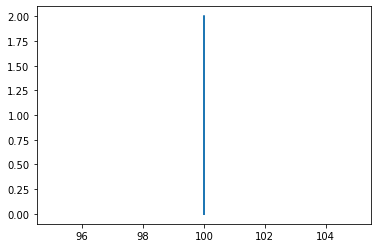

In [14]:
# noise = np.random.normal(0, 0.02, 200)
# input = stairstep(0,0.5,10,200,noise)

from matplotlib import pyplot as plt 
plt.plot(L1.sets[0].tv,L1.sets[0].input)

In [15]:
# !nrngui

In [16]:
!which nrngui

/home/tlh/myownstuff/olfactory/python_notebooks/.venv/bin/nrngui


In [17]:
h.topology()


|-|       Set [1]_Mcell [1].soma(0-1)
   `|       Set [1]_Mcell [1].dend(0-1)
 `|       Set [1]_Mcell [1].axon(0-1)
|-|       Set [1]_Mcell [2].soma(0-1)
   `|       Set [1]_Mcell [2].dend(0-1)
 `|       Set [1]_Mcell [2].axon(0-1)
|-|       Set [1]_Gcell [3].soma(0-1)
   `|       Set [1]_Gcell [3].dend(0-1)
 `|       Set [1]_Gcell [3].axon(0-1)
|-|       Set [1]_Gcell [4].soma(0-1)
   `|       Set [1]_Gcell [4].dend(0-1)
 `|       Set [1]_Gcell [4].axon(0-1)



1.0

In [18]:
from neuron import h, gui2
gui2.set_backend('jupyter')
ps = gui2.PlotShape()
ps.variable('v')
ps.show(0)

<IPython.core.display.Javascript object>

In [19]:
# plotCell(L1.sets[0].orn, 'ORN')

In [20]:
plotCell(L1.sets[0].M1, 'M1', '(4-coupled)')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [21]:
plotCell(L1.sets[0].M2, 'M2', '(4-coupled)')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [22]:
plotCell(L1.sets[0].G1, 'G1', '(4-coupled)')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [23]:
plotCell(L1.sets[0].G2, 'G2', '(4-coupled)')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

## Voltage vs Voltage analysis

## Learning

In [24]:
# import time
# tick = time.time()
# epochs = 50
# import numpy as np
# import math
# out_1_1_data = []
# A_plus = 0.01      #0.2 to 2.5
# A_minus = -0.01
# tau_pre = 20*ms
# tau_post = 20*ms

# weights_rec = [[0 for i in range(epochs)] for j in range(len(L1.sets))]
# weights_rec_2 = [[0 for i in range(epochs)] for j in range(len(L1.sets))]
# L_weights_rec= [[0 for i in range(epochs)] for j in range(len(L1.sets)-1)]
# L_weights_rec_2= [[0 for i in range(epochs)] for j in range(len(L1.sets)-1)]

# for l in range(epochs):  
#     print("\niteration no is",l)
#     P1_data = []
#     print("\nmutual learning")
#     for i in range(len(L1.sets)):
#         h.continuerun(300 *ms)
#         out_1_1 = h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)
#         # print("Spike times P{0}".format(1+i*2), list(L1.sets[i].P1.spike_times))
#         spike_1_1 = list(L1.sets[i].P1.spike_times)
#         out_1_2 = h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)
#         spike_1_2 = list(L1.sets[i].P2.spike_times)
#         # print("Spike times P{0}".format(2+i*2), list(L1.sets[i].P2.spike_times))
#         t = h.Vector().record(h._ref_t)
#         h.finitialize(-70 * mV)
        
#         for k in range(1,3):
#             # delta_t = [(spike_1_2[iter] - spike_1_1[iter]) for iter in range(min(len(spike_1_1),len(spike_1_2)))]
#             # delta_w_list = [A_plus*math.exp(-delta_t[iter]/tau_post) if delta_t[iter] >=0.24 else A_minus*math.exp(delta_t[iter]/tau_pre) for iter in range(min(len(spike_1_1),len(spike_1_2)))]
#             # delta_w = sum(delta_w_list)
#             exec(f"L1.sets[i].nc{k}.weight[0] += generate_L_weight_delta(spike_1_1, spike_1_2)")         
#         P1_data.append(spike_1_1)
#         print("weight:", L1.sets[i].nc1.weight[0])
#         weights_rec[i][l] = L1.sets[i].nc1.weight[0]
#         weights_rec_2[i][l] = L1.sets[i].nc2.weight[0]    



# #Lateral Learning
#     print("\tlateral learning")
#     for i in range(len(L1.sets)-1):
#       h.continuerun(300 *ms)
#       out_1_1 = h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)
#       print("Spike times P{0}".format(1+2*i), list(L1.sets[i].P1.spike_times))
#       spike_1_1 = list(L1.sets[i].P1.spike_times)
#       out_2_1 = h.Vector().record(L1.sets[i+1].P1.axon(0.5)._ref_v)
#       print("Spike times P{0}".format(3+2*i), list(L1.sets[i+1].P1.spike_times))
#       spike_2_1 = list(L1.sets[i+1].P1.spike_times)
#       h.finitialize(-70 * mV)

#       # change the deltas
      
#       L1.twoCupArr[i][0].weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)
#       L1.twoCupArr[i][1].weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)

#       # Logging work

#       print(L1.twoCupArr[i][0].weight[0])
#       L_weights_rec[i][l] = L1.twoCupArr[i][0].weight[0]
#       L_weights_rec[i][l] = L1.twoCupArr[i][1].weight[0]
#       # exec(f"L1.nc11_{i}.weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)")
#       # exec(f"L1.nc12_{i}.weight[0] += generate_L_weight_delta(spike_1_1, spike_2_1)")
#       # exec(f"L1.nc11_{i}.weight[0] += generate_L_weight_delta(spike_M1_data[i], spike_M1_data[i+1])")
#       # exec(f"L1.nc12_{i}.weight[0] += generate_L_weight_delta(spike_M1_data[i+1], spike_M1_data[i])")
#       # print("lateral weight is : ",L1.nc11_0.weight[0])  
#       # L_weights_rec[i][l] = L1.nc11_0.weight[0]
#       # L_weights_rec_2[i][l]=L1.nc12_i.weight[0] 
#       # exec(f"print(L1.nc11_{i}.weight[0])")
#       # exec(f"L_weights_rec[i][l]=L1.nc11_{i}.weight[0]")
#       # exec(f"L_weights_rec_2[i][l]=L1.nc12_{i}.weight[0]")

# tock = time.time()
# print("Time elapsed in seconds is: ", tock-tick)

In [25]:
import sys, time
tick = time.time()
epochs = 20
weight_data = []

out = display(progress(0, epochs), display_id=True)

for l in range(epochs):
    #print("iteration no is",l)
    out.update(progress(l, epochs))    
    # print("\nmutual learning")
    P1_axon_data = []
    P1_dend_data = []
    P2_axon_data = []
    P2_dend_data = []
    M1_axon_data = []
    M1_dend_data = []
    M2_axon_data = []
    M2_dend_data = []
    G1_axon_data = []
    G1_dend_data = []
    G2_axon_data = []
    G2_dend_data = []
    P1_spike_times = []
    P2_spike_times = []
    M1_spike_times = []
    M2_spike_times = []
    G1_spike_times = []
    G2_spike_times = []

    h.finitialize(-70* mV)
    h.continuerun(300*ms)
    t = h.Vector().record(h._ref_t)
    
    for i in range(len(L1.sets)):
    #     P1_axon_data.append(list(h.Vector().record(L1.sets[i].P1.axon(0.5)._ref_v)))
    #     P1_dend_data.append(list(h.Vector().record(L1.sets[i].P1.dend(0.5)._ref_v)))
    #     P1_spike_times.append(list(L1.sets[i].P1.spike_times))
    #     P2_axon_data.append(list(h.Vector().record(L1.sets[i].P2.axon(0.5)._ref_v)))
    #     P2_spike_times.append(list(L1.sets[i].P2.spike_times))
    #     P2_dend_data.append(list(h.Vector().record(L1.sets[i].P2.dend(0.5)._ref_v)))
        M1_axon_data.append(list(h.Vector().record(L1.sets[i].M1.axon(0.5)._ref_v)))
        M1_dend_data.append(list(h.Vector().record(L1.sets[i].M1.dend(0.5)._ref_v)))
        M1_spike_times.append(list(L1.sets[i].M1.spike_times))
        M2_axon_data.append(list(h.Vector().record(L1.sets[i].M2.axon(0.5)._ref_v)))
        M2_dend_data.append(list(h.Vector().record(L1.sets[i].M2.dend(0.5)._ref_v)))
        M2_spike_times.append(list(L1.sets[i].M2.spike_times))
        G1_axon_data.append(list(h.Vector().record(L1.sets[i].G1.axon(0.5)._ref_v)))
        G1_dend_data.append(list(h.Vector().record(L1.sets[i].G1.dend(0.5)._ref_v)))
        G1_spike_times.append(list(L1.sets[i].G1.spike_times))
        G2_axon_data.append(list(h.Vector().record(L1.sets[i].G2.axon(0.5)._ref_v)))
        G2_dend_data.append(list(h.Vector().record(L1.sets[i].G2.dend(0.5)._ref_v)))
        G2_spike_times.append(list(L1.sets[i].G2.spike_times))

   
    # h.finitialize(-70 * mV)

    for i in range(len(L1.sets)):
        # # 2-coupled STDP-based learning
        # L1.sets[i].nc1.weight[0] += generate_L_weight_delta(P1_spike_times[i], P2_spike_times[i])
        # # logging
        # # print("P1_axon", P1_spike_times[i], P2_spike_times[i])
        # L1.sets[i].nc2.weight[0] += generate_L_weight_delta(P2_spike_times[i], P1_spike_times[i])
        # 4-coupled STDP-based learning
        L1.sets[i].nc4.weight[0] += generate_L_weight_delta(M1_spike_times[i], M2_spike_times[i])
        L1.sets[i].nc5.weight[0] += generate_L_weight_delta(M2_spike_times[i], M1_spike_times[i])
        L1.sets[i].nc6.weight[0] += generate_L_weight_delta(M2_spike_times[i], G1_spike_times[i])
        L1.sets[i].nc7.weight[0] += generate_L_weight_delta(G1_spike_times[i], M2_spike_times[i])
        L1.sets[i].nc8.weight[0] += generate_L_weight_delta(G1_spike_times[i], G2_spike_times[i])
        L1.sets[i].nc9.weight[0] += generate_L_weight_delta(G2_spike_times[i], G1_spike_times[i])
        L1.sets[i].nc10.weight[0] += generate_L_weight_delta(G2_spike_times[i], M1_spike_times[i])
        L1.sets[i].nc11.weight[0] += generate_L_weight_delta(M1_spike_times[i], G2_spike_times[i])
        L1.sets[i].nc12.weight[0] += generate_L_weight_delta(M1_spike_times[i], G1_spike_times[i])
        L1.sets[i].nc13.weight[0] += generate_L_weight_delta(G1_spike_times[i], M1_spike_times[i])
        
    # do a proper logging function
    weight_data.append(L1.sets[0].nc4.weight[0])


    # #Lateral Learning
    # for i in range(len(L1.sets)-1):
    #     # 2-coupled part
    #     # L1.twoCupArr[i][0].weight[0] += generate_L_weight_delta(P1_spike_times[i], P1_spike_times[i+1])
    #     # L1.twoCupArr[i][1].weight[0] += generate_L_weight_delta(P1_spike_times[i+1], P1_spike_times[i])
    #     # 4-coupled part
    #     L1.fourCupArr[i][0].weight[0] += generate_L_weight_delta(M1_spike_times[i], M1_spike_times[i+1])
    #     L1.fourCupArr[i][1].weight[0] += generate_L_weight_delta(M1_spike_times[i+1], M1_spike_times[i])
    #     L1.fourCupArr[i][2].weight[0] += generate_L_weight_delta(G1_spike_times[i], G1_spike_times[i+1])
    #     L1.fourCupArr[i][3].weight[0] += generate_L_weight_delta(G1_spike_times[i+1], G1_spike_times[i])


out.update(progress(epochs, epochs))    
tock = time.time()
print("The time it took to learn", tock-tick, "seconds")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The time it took to learn 1.4057848453521729 seconds


In [26]:
# h.continuerun(300 * ms)
# t = h.Vector().record(h._ref_t)
# v = h.Vector().record(L1.sets[0].P1.axon(0.5)._ref_v)
# lis = []
# lis.append(list(L1.sets[0].P1.spike_times))
# lis

In [27]:
print(weight_data)
f = plt2.figure(x_axis_label='epochs')
x = [i for i in range(epochs)]
f.line(x, weight_data, line_width=1, line_color='black')
plt2.show(f)

[0.4328241765350421, 0.5671121180442563, 0.6033200713647309, 0.6075415647809062, 0.6016065339956598, 0.5760305001553705, 0.550732518407074, 0.5239311381818624, 0.4969214129816146, 0.46979267276114445, 0.44888279159255495, 0.42800789701026765, 0.4071504409230574, 0.38629778569055795, 0.3654030734306571, 0.3444750635507027, 0.3235959495350685, 0.30272288961738586, 0.2879970022748482, 0.27329418235359637]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [28]:
plotCell(L1.sets[-1].M1, 'M1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [29]:
plotCell(L1.sets[-1].G1, 'G1')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [30]:
plotCell(L1.sets[-1].M2, 'M2')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [31]:
plotCell(L1.sets[-1].G2, 'G2')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [32]:
# f1 = plt2.figure(x_axis_label='epoch', y_axis_label='weights')
# x = [i for i in range(len(weight_data))]
# f1.line(x, weight_data, line_width=1, legend_label='pair.no.{iter+1}', line_color='black')
# plt2.show(f1)

In [33]:
# plotCell(L1.DPC, 'DPC')

In [34]:
# plotCell(L1.AON.M1, 'AON')

In [35]:
# plotCell(L1.PC.G1, 'Pyramidal Cell')

In [36]:
# recording_cell = L1.sets[-1].M1
# # recording_cell_2 = L1.AON.M1
# axon_m1 = h.Vector().record(recording_cell.axon(0.5)._ref_v)
# dend_m1 = h.Vector().record(recording_cell.dend(0.5)._ref_v)
# axon_m2 = h.Vector().record(recording_cell_2.axon(0.5)._ref_v)
# dend_m2 = h.Vector().record(recording_cell_2.dend(0.5)._ref_v)
# t = h.Vector().record(h._ref_t)

# h.finitialize(-70 * mV)
# h.continuerun(200 * ms)

# f = plt2.figure(x_axis_label='M1 Axon v (mV)', y_axis_label='AON Axon v (mV)')
# f.line(list(axon_m1), list(axon_m2), line_width=1,legend_label='4-coupled M1 axon vs AON axon',line_color='black')
# f2 = plt2.figure(x_axis_label='M1 Dendrite v (mV)', y_axis_label='AON dendrite v (mV)')
# f2.line(list(dend_m1), list(dend_m2), line_width=2,legend_label='4-coupled M1 dendrite vs AON dendrite',line_color='black')
# plt2.show(f)
# plt2.show(f2)

In [37]:
totalend = time.time()
print("Total time it took: ", totalend-totalstart)

Total time it took:  9.925188541412354
